In [1]:
using POMDPs
using Plots
using Random
using LinearAlgebra
# using ElectronDisplay

In [2]:
# Drone State Struct
struct DroneState
    x::Float64 
    y::Float64
    v::Float64
    θ::Float64 # heading angle
end

In [3]:

### Drone Action Struct
struct DroneAction  ###CHECK how to define a = -1:1 and Δθ = 0:2pi
    a::Float64
    Δθ::Float64 
end
### Obstacle and Target area Struct
struct Circle
    x::Float64
    y::Float64
    r::Float64
end
### Struct drone MDP
mutable struct Dronemdp <: MDP{DroneState, DroneAction}
    size::Tuple{Float64, Float64} 
    drone::DroneState
    target::Circle 
    max_velocity::Float64
    max_acceleration::Float64
    max_angle::Float64
    discount::Float64
    isterminal::Bool
    obstacles::Vector{Circle}
    initial_state::DroneState
end;

In [4]:
### generate random obstacles
function generate_obstacles(size::Tuple{Float64, Float64}, num_obstacles::Int64, target::Circle)
    obstacles = Vector{Circle}()
    min_radius= 2.5
    max_radius = 7.5
    for _ in 1:num_obstacles
        obstacle_x, obstacle_y = rand(1.0:size[1]), rand(1.0:size[2])
        obstacle_r = rand(min_radius:max_radius)

        ## if target and obstacle regions overlap, generate new obstacle
        while norm([target.x, target.y].- [obstacle_x, obstacle_y]) < target.r + obstacle_r
            obstacle_x, obstacle_y = rand(1.0:size[1]), rand(1.0:size[2])
            obstacle_r = rand(min_radius:max_radius)
        end

        obstacle = Circle(obstacle_x, obstacle_y, obstacle_r)
        push!(obstacles, obstacle)
    end
    return obstacles
end;

In [5]:
### mdpironment constructor
function Dronemdp(;
        size::Tuple{Float64, Float64}=(50.0,50.0),
        drone::DroneState=DroneState(2.0, 2.0, 0.0, 0.0),
        max_velocity::Float64=1.0,
        max_acceleration::Float64=10.0,
        max_angle::Float64=2*pi,
        discount::Float64=0.99,
        isterminal::Bool=false,
        initial_state=DroneState(2.0, 2.0, 0.0, 0.0)
        )
    ## for testing purposes
    Random.seed!(1);
    ## set random target location
    target = Circle(rand(1.0:size[1]), rand(1.0:size[2]), 5.0)
    ## define random obstacles
    obstacles = generate_obstacles(size, 10, target)
    return Dronemdp(size, drone, target, max_velocity, max_acceleration, max_angle, discount, isterminal, obstacles, initial_state)
end;

In [6]:
### terminal condition handling
function isterminal(mdp::Dronemdp)
    distance_to_target = norm([mdp.drone.x, mdp.drone.y].- [mdp.target.x, mdp.target.y])
    if distance_to_target <= mdp.target.r
        return 1
    end

    for i in 1:length(mdp.obstacles)
        distance_to_obstacle = norm([mdp.drone.x, mdp.drone.y].- [mdp.obstacles[i].x, mdp.obstacles[i].y])
        if distance_to_obstacle <= mdp.obstacles[i].r
            return 2
        end
    end

    # check for out of bounds
    if mdp.drone.x >= mdp.size[1] || mdp.drone.x <= 0 || mdp.drone.y >= mdp.size[2] || mdp.drone.y <= 0
        return 3
    end

    return 0
end;

In [7]:
### transition function
function POMDPs.transition(mdp::Dronemdp, action::DroneAction)
    time_step = 1

    x = mdp.drone.x
    y = mdp.drone.y
    v = mdp.drone.v
    θ = mdp.drone.θ

    a = action.a
    Δθ = action.Δθ

    v_new = clamp(v + a*time_step, -mdp.max_velocity, mdp.max_velocity)
    θ_new = mod( θ + Δθ,mdp.max_angle)

    x_new = x + v_new*cos(θ_new)
    y_new = y + v_new*sin(θ_new)

    mdp.drone = DroneState(x_new,y_new,v_new,θ_new)
    if isterminal(mdp) != 0
        mdp.isterminal = true
    end
    return mdp.drone
end;

In [8]:
### reward function
function POMDPs.reward(mdp::Dronemdp,action::DroneAction)
    if isterminal(mdp) == 1
        return 100.0
    elseif isterminal(mdp) == 2
        return -1000.0
    elseif isterminal(mdp) == 3
        return -1000.0
    else
        return -1
    end
end;

In [9]:
### discount
POMDPs.discount(mdp::Dronemdp) = mdp.discount;

In [10]:
### generate next state sp, and reward r 
function POMDPs.gen(mdp::Dronemdp, action::DroneAction)
    sp = POMDPs.transition(mdp, action)
    r = POMDPs.reward(mdp,action)

    return sp, r
end;

In [11]:
### reset mdp
function reset!(mdp::Dronemdp)
    mdp.drone = mdp.initial_state
    mdp.isterminal = false
end;

In [12]:
### generate target manually
function set_target!(mdp::Dronemdp, target::Circle)
    mdp.target = target
end;

In [13]:
### Generate points for the circle
function plot_circle(x, y, r, fill_color=:none)
    theta = LinRange(0, 2π, 100)  # Angle range from 0 to 2π
    circle_x = x .+ r * cos.(theta)
    circle_y = y .+ r * sin.(theta)
    return plot!(circle_x, circle_y, aspect_ratio=1, legend=false, fillalpha=0.7, fillopacity=0.7, fill=true, fillcolor=fill_color)
end
### Render MDP 
function render(mdp::Dronemdp; show=true, t=nothing)
    p = plot(size=(500, 500), xlim=(-2, mdp.size[1]+2), ylim=(-2, mdp.size[2]+2), legend=false)
    xticks!(0:5:mdp.size[1]+1)
    yticks!(0:5:mdp.size[2]+1)
    for (i, obs) in enumerate(mdp.obstacles)
        plot_circle(obs.x, obs.y, obs.r,:red)
    end
    plot_circle(mdp.target.x, mdp.target.y, mdp.target.r,:green)
    quiver!([mdp.drone.x], [mdp.drone.y], quiver=[(1*cos(mdp.drone.θ), 1*sin(mdp.drone.θ))], color=:blue, arrow=true, linewidth=2)
    
    plot!([0.5, 0.5], [0.5, 50.5], color=:black, linewidth=2)  # (0.5,0.5) to (0.5,10.5)
    plot!([0.5, 50.5], [0.5, 0.5], color=:black, linewidth=2)  # (0.5,0.5) to (10.5,0.5)
    plot!([0.5, 50.5], [50.5, 50.5], color=:black, linewidth=2)  # (0.5,10.5) to (10.5,10.5)
    plot!([50.5, 50.5], [50.5, 0.5], color=:black, linewidth=2)  # (10.5,10.5) to (10.5,0.5)

    if !isnothing(t)
        annotate!(mdp.size[1]/2, mdp.size[2]-2, text("t=$t", :center, 12))
    end

    if show
        display(p)
    end
end
### Create animation
function create_animation(batch_mdp::Vector{Dronemdp})
    anim = @animate for i in eachindex(batch_mdp)
        render(batch_mdp[i], show=false, t=i)
    end

    return anim
end;


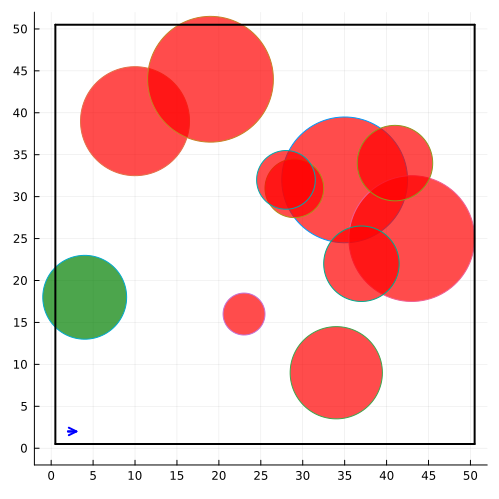

In [14]:
mdp = Dronemdp()
render(mdp)